<a href="https://colab.research.google.com/github/prav2909/Deep_learning/blob/master/Graph_Embedding_IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Work in progress***

Graph embedding using IMDB Database

References:
https://www.analyticsvidhya.com/blog/2019/11/graph-feature-extraction-deepwalk/

Database link: 

title.basics.tsv.gz
https://www.imdb.com/interfaces/

In [42]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
mdb = pd.read_csv("data.tsv", sep = "\t", nrows=50) #usecols=['genres', 'primaryTitle']
for index, row in mdb.iterrows():
  a = row['genres'].split(",")
  mdb['genres'][index] = a[0]

mdb = mdb.sort_values(by='genres', axis=0)
print(mdb.head(10))

       tconst titleType  ... runtimeMinutes     genres
11  tt0000012     short  ...              1     Action
39  tt0000041     short  ...              1     Action
1   tt0000002     short  ...              5  Animation
2   tt0000003     short  ...              4  Animation
3   tt0000004     short  ...             12  Animation
14  tt0000015     short  ...              2  Animation
4   tt0000005     short  ...              1     Comedy
18  tt0000019     short  ...             \N     Comedy
31  tt0000033     short  ...              1     Comedy
33  tt0000035     short  ...              1     Comedy

[10 rows x 9 columns]


In [5]:
#NOT USED
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[=================================================-] 98.9% 1645.2/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [126]:
G = nx.from_pandas_edgelist(mdb, "genres", "primaryTitle", edge_attr=None, create_using=nx.Graph())

57


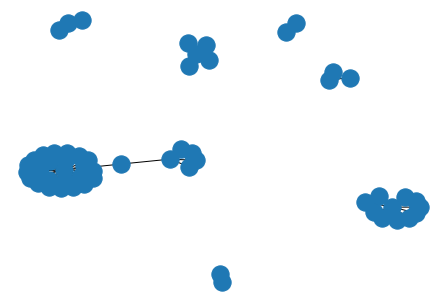

In [127]:
print(len(G))
nx.draw(G)

In [128]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [129]:
get_randomwalk('Comedy', 20)

['Comedy', 'Trick Riding']

In [130]:
# get list of all nodes from the graph
all_nodes = list(G.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))
        
# count of sequences
len(random_walks)

100%|██████████| 57/57 [00:00<00:00, 6846.96it/s]


285

In [131]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [132]:
# train skip-gram (word2vec) model
model = Word2Vec(window = 2, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(4684, 16460)

In [134]:
model.similar_by_word('Documentary')

[('Short', 0.984034538269043),
 ('Comedy', 0.9759213924407959),
 ('Animation', 0.9637303352355957),
 ('Barnet Horse Fair', 0.9517174959182739),
 ('Les blanchisseuses', 0.9466201066970825),
 ('Das boxende Känguruh', 0.9441068172454834),
 ('The Ball Game', 0.943045973777771),
 ('Bateau-mouche sur la Seine', 0.938555121421814),
 ('The Waterer Watered', 0.9357988834381104),
 ('Le clown et ses chiens', 0.9323971271514893)]